FINAL MODEL TRAINING PIPELINE — SENTIMENT + EMOTION + TOPIC
Using 37 numeric features.

🔀 Splitting train/test data...
✔ Train size: 667, Test size: 167

🟦 Training Naive Bayes...

🟩 Training Logistic Regression...

🟧 Training Random Forest...

🤝 Building sentiment ensemble...

📊 SENTIMENT PERFORMANCE
NB         | Acc: 0.6647 | Macro F1: 0.4428
LR         | Acc: 0.8982 | Macro F1: 0.8260
RF         | Acc: 0.9940 | Macro F1: 0.9859
Ensemble   | Acc: 0.9880 | Macro F1: 0.9710

Classification Report — Sentiment Ensemble:

              precision    recall  f1-score   support

    Negative       0.97      1.00      0.98        63
     Neutral       1.00      0.87      0.93        15
    Positive       1.00      1.00      1.00        89

    accuracy                           0.99       167
   macro avg       0.99      0.96      0.97       167
weighted avg       0.99      0.99      0.99       167


📘 5-Fold Cross-Validation (Sentiment Models)

LR CV Mean: 0.8935
RF CV Mean: 0.9775
NB CV Mea

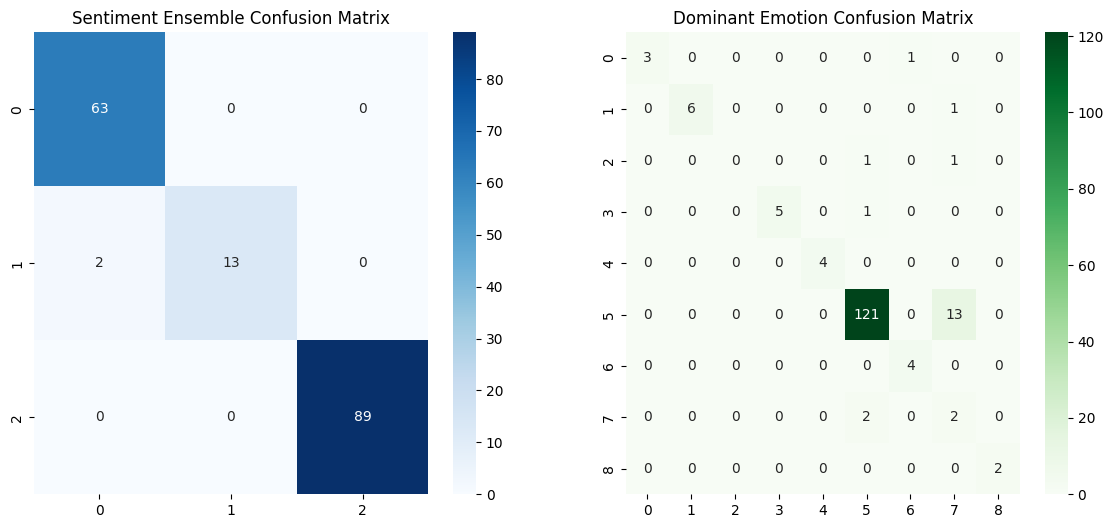

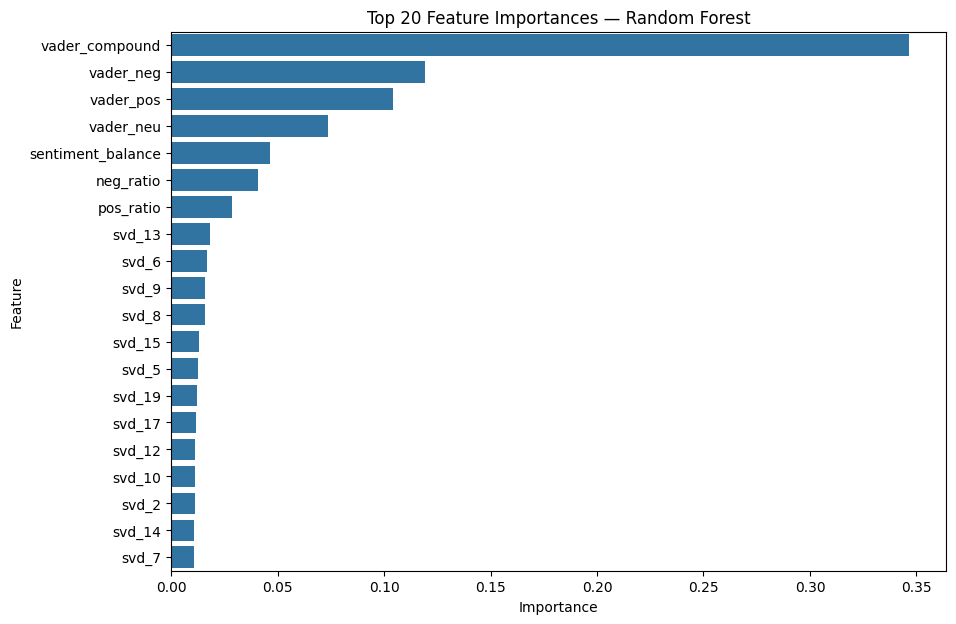


🧠 Generating Final Mood Predictions (9-category)...

🎯 Final Mood Prediction Table:
                                                text sentiment_pred  \
0  a treasure trove of criterion collection dvds ...       Positive   
1  legos first star trek set is a enterprise with...       Negative   
2  sudanese familys home daubed with racist graff...       Negative   
3  sports pirates just got some bad news amazons ...       Negative   
4  former ravenna teacher pleads to federal sexua...        Neutral   

   emo_prob_anger  emo_prob_anticipation  emo_prob_disgust  emo_prob_fear  \
0        0.000009               0.024299      8.386066e-29       0.019854   
1        0.000049               0.058933      8.415497e-29       0.022898   
2        0.001084               0.032604      9.068220e-29       0.109359   
3        0.000202               0.040783      6.690261e-29       0.079325   
4        0.000088               0.042367      1.610276e-28       0.094979   

   emo_prob_joy  emo_prob

In [ ]:
#Doign the model trainign 

#First installing all the imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")

print("="*70)
print("FINAL MODEL TRAINING PIPELINE — SENTIMENT + EMOTION + TOPIC")
print("="*70)

#Takign the engineered features
df_features = pd.read_csv("../data/engineered_features.csv")
df_base = pd.read_csv("../data/cleaned_news_data.csv")

df_base["cleaned_text"] = df_base["cleaned_text"].fillna("")

assert len(df_features) == len(df_base), "❌ Row alignment mismatch!"

texts = df_base["cleaned_text"]
topics = df_base["topic"]

#Deciding what is the target
#Based on vader score
POS_TH = 0.1
NEG_TH = -0.1

y_sentiment = df_features["sentiment_category"]

y_emotion = df_features["dominant_emotion"]

#Takign the important features
emotion_ratios = [
    f"{emo}_ratio" for emo in [
        "fear","anger","sadness","joy",
        "trust","anticipation","disgust","surprise"
    ]
]

sentiment_features = ["pos_ratio", "neg_ratio", "sentiment_balance"]
toxicity_features = ["toxicity_count", "toxicity_ratio"]

vader_features = ["vader_compound", "vader_pos", "vader_neg", "vader_neu"]

svd_features = [f"svd_{i}" for i in range(1, 21)]

feature_cols = (
    emotion_ratios
    + sentiment_features
    + vader_features
    + svd_features
    + toxicity_features
)

# Validate existence
missing = [c for c in feature_cols if c not in df_features.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

X = df_features[feature_cols].fillna(0)

print(f"Using {X.shape[1]} numeric features.")

#Uisng training and testing
#Ratio is 80% for training and 20% for testing
#Cross validation is used to find the optimal valude and hyperparameters and to validate the model
print("\n🔀 Splitting train/test data...")

# Step 1: Split indices first (preserves original DataFrame indices)
train_idx, test_idx = train_test_split(
    X.index, 
    test_size=0.2, 
    stratify=y_sentiment, 
    random_state=42
)

# Step 2: Use these indices to split everything correctly
X_train = X.loc[train_idx]
X_test = X.loc[test_idx]

y_train_sent = y_sentiment.loc[train_idx]
y_test_sent = y_sentiment.loc[test_idx]

y_train_emo = y_emotion.loc[train_idx]
y_test_emo = y_emotion.loc[test_idx]

texts_train = texts.loc[train_idx]
texts_test = texts.loc[test_idx]

topics_test = topics.loc[test_idx]

# Save indices for reproducibility
pickle.dump({"train_idx": train_idx, "test_idx": test_idx},
            open("../models/train_test_indices.pkl", "wb"))

print(f"✔ Train size: {len(train_idx)}, Test size: {len(test_idx)}")
#Using naive bayes
print("\nTraining Naive Bayes...")
tfidf = TfidfVectorizer(max_features=3000, stop_words="english")
X_train_tfidf = tfidf.fit_transform(texts_train)
X_test_tfidf  = tfidf.transform(texts_test)

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_sent)

#Using logistic regression
print("\nTraining Logistic Regression...")
lr_model = Pipeline([
    ("scale", MinMaxScaler()),
    ("lr", LogisticRegression(
        max_iter=800, class_weight="balanced", random_state=42
    ))
])
lr_model.fit(X_train, y_train_sent)

#Using random forest
print("\nTraining Random Forest...")
rf_base = RandomForestClassifier(
    n_estimators=350, class_weight="balanced", random_state=42
)
rf_model = CalibratedClassifierCV(rf_base, method="sigmoid", cv=3)
rf_model.fit(X_train, y_train_sent)

#soft ensemble
print("\nBuilding sentiment ensemble...")

def align_probabilities(model, X, target_classes):
    """Align model probabilities to match target class order"""
    proba = model.predict_proba(X)
    model_classes = list(model.classes_)
    
    # Create aligned probability matrix
    aligned = np.zeros((X.shape[0], len(target_classes)))
    
    for i, target_cls in enumerate(target_classes):
        if target_cls in model_classes:
            j = model_classes.index(target_cls)
            aligned[:, i] = proba[:, j]
    
    return aligned

# Define canonical class order
target_classes = np.array(sorted(np.unique(y_sentiment)))


# Align all models to same class order
p_nb = align_probabilities(nb_model, X_test_tfidf, target_classes)
p_lr = align_probabilities(lr_model, X_test, target_classes)
p_rf = align_probabilities(rf_model, X_test, target_classes)

# Now safe to average
final_prob = 0.2*p_nb + 0.3*p_lr + 0.5*p_rf
y_pred_sent = target_classes[np.argmax(final_prob, axis=1)]


print("\nSENTIMENT PERFORMANCE")

sent_results = {
    "NB": nb_model.predict(X_test_tfidf),
    "LR": lr_model.predict(X_test),
    "RF": rf_model.predict(X_test),
    "Ensemble": y_pred_sent
}

for name, pred in sent_results.items():
    print(f"{name:10s} | Acc: {accuracy_score(y_test_sent, pred):.4f} "
          f"| Macro F1: {f1_score(y_test_sent, pred, average='macro'):.4f}")

print("\nClassification Report — Sentiment Ensemble:\n")
print(classification_report(y_test_sent, y_pred_sent))


print("\n5-Fold Cross-Validation (Sentiment Models)")

# LR CV
cv_lr = cross_val_score(lr_model, X_train, y_train_sent, cv=5, scoring="accuracy")
print("\nLR CV Mean:", cv_lr.mean().round(4))

# RF CV
cv_rf = cross_val_score(rf_base, X_train, y_train_sent, cv=5, scoring="accuracy")
print("RF CV Mean:", cv_rf.mean().round(4))

# NB CV
from sklearn.pipeline import Pipeline

# Create pipeline that fits TF-IDF + NB together
nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, stop_words="english")),
    ('nb', MultinomialNB())
])

# Now CV properly tests the entire pipeline
cv_nb = cross_val_score(nb_pipeline, texts_train, y_train_sent, cv=5, scoring="accuracy")
print("NB CV Mean:", cv_nb.mean().round(4))


print("\nTraining Emotion Classifier...")

emotion_model = Pipeline([
    ("scale", MinMaxScaler()),
    ("lr", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42,
        solver="saga"
    ))
])

emotion_model.fit(X_train, y_train_emo)
emo_pred = emotion_model.predict(X_test)

print("\nEmotion Classification Report:\n")
print(classification_report(y_test_emo, emo_pred))

# CV Fold for Emotion
cv_emo = cross_val_score(emotion_model, X_train, y_train_emo, cv=5, scoring="accuracy")
print("\nEmotion Model CV Mean:", cv_emo.mean().round(4))


print("\n" + "="*70)
print("TOPIC → PREDICTED SENTIMENT DISTRIBUTION")
print("="*70)

analysis_df = pd.DataFrame({
    "topic": topics_test,
    "sentiment": y_pred_sent,
    "emotion": emo_pred
})

sentiment_by_topic = (
    analysis_df.groupby("topic")["sentiment"]
    .value_counts(normalize=True)
    .mul(100)
    .unstack(fill_value=0)
)
print(sentiment_by_topic.round(1))

print("\nDominant Emotion by Topic:\n")
dom_emo = (
    analysis_df.groupby("topic")["emotion"]
    .value_counts()
    .unstack(fill_value=0)
    .idxmax(axis=1)
)
print(dom_emo)

#Creating confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(confusion_matrix(y_test_sent, y_pred_sent),
            annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Sentiment Ensemble Confusion Matrix")

sns.heatmap(confusion_matrix(y_test_emo, emo_pred),
            annot=True, fmt="d", cmap="Greens", ax=ax[1])
ax[1].set_title("Dominant Emotion Confusion Matrix")

plt.show()

#Taking feature importance for random forest
rf_inner = rf_model.calibrated_classifiers_[0].estimator

importances = rf_inner.feature_importances_
fi_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(y="Feature", x="Importance", data=fi_df.head(20))
plt.title("Top 20 Feature Importances — Random Forest")
plt.show()
#This is final mood prediction
print("\nGenerating Final Mood Predictions (9-category)...")

# 1) Main sentiment
sentiment_pred = y_pred_sent 

# 2) Emotion model prediction (1 dominant emotion, but we want probabilities)
emotion_proba = emotion_model.predict_proba(X_test)
emotion_labels = emotion_model.named_steps["lr"].classes_

# 3) Raw emotion ratios (for transparency)
emotion_ratio_cols = [
    "fear_ratio", "anger_ratio", "sadness_ratio", "joy_ratio",
    "trust_ratio", "anticipation_ratio", "disgust_ratio", "surprise_ratio"
]
emotion_ratios_test = X_test[emotion_ratio_cols]


mood_df = pd.DataFrame({
    "text": texts_test.values,
    "sentiment_pred": sentiment_pred,
})

# Add emotion probabilities as columns
for i, emo in enumerate(emotion_labels):
    mood_df[f"emo_prob_{emo}"] = emotion_proba[:, i]

# Add raw ratios
for col in emotion_ratio_cols:
    mood_df[col] = emotion_ratios_test[col].values

print("\nFinal Mood Prediction Table:")
print(mood_df.head())

# Save mood predictions for inspection
mood_df.to_csv("../data/final_mood_predictions.csv", index=False)
print("\n✔ Mood predictions saved → final_mood_predictions.csv")

#Takign the model and saving it 
print("\nSaving all models...")

pickle.dump(nb_model, open("../models/sentiment_nb.pkl", "wb"))
pickle.dump(lr_model, open("../models/sentiment_lr.pkl", "wb"))
pickle.dump(rf_model, open("../models/sentiment_rf.pkl", "wb"))
pickle.dump(tfidf, open("../models/tfidf_vectorizer.pkl", "wb"))
pickle.dump(target_classes, open("../models/sentiment_labels.pkl", "wb"))  # FIXED

pickle.dump(emotion_model, open("../models/emotion_lr.pkl", "wb"))
pickle.dump(
    emotion_model.named_steps["lr"].classes_,
    open("../models/emotion_labels.pkl", "wb")
)

print("="*70)


In [12]:
# ================================================================
# 15B) TOPIC-LEVEL MOOD PREDICTION
# ================================================================
print("\n📌 Generating Mood Prediction BY TOPIC...\n")

mood_df_full = mood_df.copy()
mood_df_full["topic"] = topics_test.values

# ------------------------------------------------
# 1. Sentiment distribution per topic
# ------------------------------------------------
sentiment_topic_dist = (
    mood_df_full.groupby("topic")["sentiment_pred"]
    .value_counts(normalize=True)
    .mul(100)
    .unstack(fill_value=0)
)

print("\n🟦 Sentiment Distribution by Topic (%):")
print(sentiment_topic_dist.round(1))


# ------------------------------------------------
# 2. Emotion probability distribution per topic
# ------------------------------------------------
emotion_prob_cols = [c for c in mood_df_full.columns if c.startswith("emo_prob_")]

emotion_topic_dist = (
    mood_df_full.groupby("topic")[emotion_prob_cols]
    .mean()
    .mul(100)
)

print("\n🟩 Average Emotion Probabilities by Topic (%):")
print(emotion_topic_dist.round(1))


# ------------------------------------------------
# 3. Dominant mood per topic
# ------------------------------------------------
def get_dominant_mood(row):
    emo_cols = emotion_prob_cols
    return emo_cols[np.argmax(row[emo_cols].values)]

dominant_mood = (
    mood_df_full.groupby("topic")[emotion_prob_cols]
    .mean()
    .apply(get_dominant_mood, axis=1)
)

dominant_mood = dominant_mood.str.replace("emo_prob_", "")

print("\n🟪 Dominant Mood by Topic:")
print(dominant_mood)


# ------------------------------------------------
# 4. Combined Topic Mood Score
# ------------------------------------------------

# A simple interpretable formula:
# MoodScore = Positive% + Joy% + Trust% - Negative% - Fear% - Anger% - Disgust%

combined_mood = pd.DataFrame()

combined_mood["Positive"] = sentiment_topic_dist.get("Positive", 0)
combined_mood["Negative"] = sentiment_topic_dist.get("Negative", 0)

combined_mood["Joy"] = emotion_topic_dist.get("emo_prob_joy", 0)
combined_mood["Trust"] = emotion_topic_dist.get("emo_prob_trust", 0)

combined_mood["Fear"] = emotion_topic_dist.get("emo_prob_fear", 0)
combined_mood["Anger"] = emotion_topic_dist.get("emo_prob_anger", 0)
combined_mood["Disgust"] = emotion_topic_dist.get("emo_prob_disgust", 0)

combined_mood["MoodScore"] = (
    combined_mood["Positive"]
    + combined_mood["Joy"]
    + combined_mood["Trust"]
    - combined_mood["Negative"]
    - combined_mood["Fear"]
    - combined_mood["Anger"]
    - combined_mood["Disgust"]
).round(1)

print("\n🔮 Combined Mood Score by Topic:")
print(combined_mood.sort_values("MoodScore", ascending=False))

# Save all topic-level results
topic_output = {
    "sentiment_topic_dist": sentiment_topic_dist,
    "emotion_topic_dist": emotion_topic_dist,
    "dominant_mood": dominant_mood,
    "combined_mood": combined_mood
}

pickle.dump(topic_output, open("../models/topic_mood_summary.pkl", "wb"))

print("\n✔ Topic-level mood prediction saved → topic_mood_summary.pkl")



📌 Generating Mood Prediction BY TOPIC...


🟦 Sentiment Distribution by Topic (%):
sentiment_pred  Negative  Neutral  Positive
topic                                      
climate             42.9      9.5      47.6
crime               80.0      0.0      20.0
economy             45.5      0.0      54.5
education           46.7      6.7      46.7
entertainment       26.7     13.3      60.0
health              34.8      4.3      60.9
politics            42.9      7.1      50.0
sports              16.0      8.0      76.0
technology           8.3     33.3      58.3

🟩 Average Emotion Probabilities by Topic (%):
               emo_prob_anger  emo_prob_anticipation  emo_prob_disgust  \
topic                                                                    
climate                   0.0                    7.2               0.0   
crime                    12.4                    2.6               0.0   
economy                   0.0                    7.6               0.0   
education       

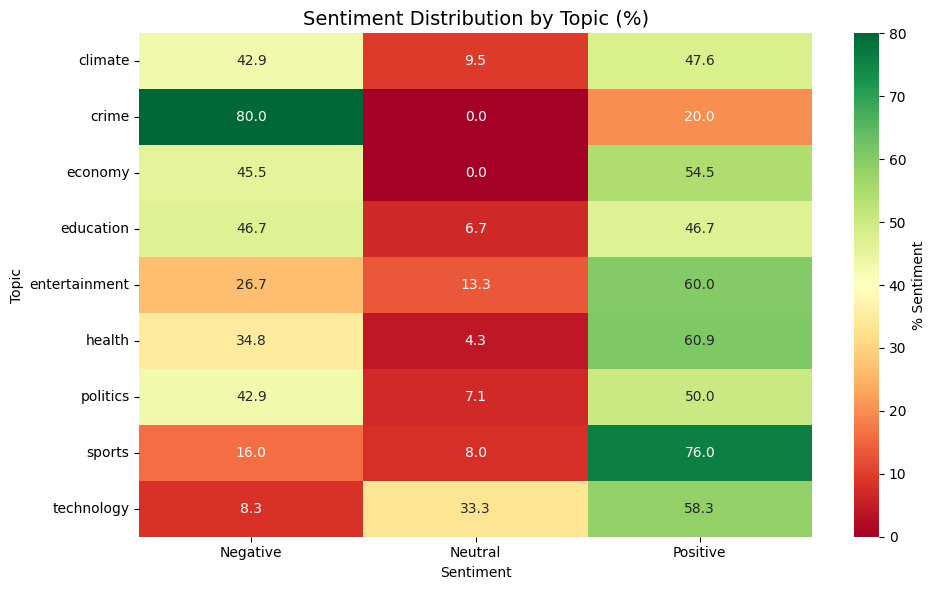

In [13]:
# ================================================================
# VIS 1 — SENTIMENT DISTRIBUTION HEATMAP (TOPIC × SENTIMENT)
# ================================================================

plt.figure(figsize=(10, 6))
sns.heatmap(
    sentiment_topic_dist,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    cbar_kws={"label": "% Sentiment"}
)
plt.title("Sentiment Distribution by Topic (%)", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


In [16]:
# ================================================================
# BUILD EMOTION PROBABILITY MATRIX PER TOPIC
# ================================================================

# Collect emotion probabilities into a DataFrame
emotion_prob_cols = [f"emo_prob_{emo}" for emo in emotion_labels]

emo_prob_df = pd.DataFrame(emotion_proba, columns=emotion_prob_cols)
emo_prob_df["topic"] = topics_test.values

# Compute mean emotion probability per topic
emotion_topic_dist = (
    emo_prob_df.groupby("topic")[emotion_prob_cols]
    .mean()
    .round(3)
)
print("\nEmotion probability distribution by topic:")
print(emotion_topic_dist)
# ================================================================
# VIS 2 — EMOTION RADAR PLOT FOR A TOPIC
# ================================================================
import numpy as np

def plot_emotion_radar(topic_name):
    if topic_name not in emotion_topic_dist.index:
        print(f"Topic '{topic_name}' not found.")
        return
    
    # Extract row of emotion probabilities
    values = emotion_topic_dist.loc[topic_name].values
    labels = [col.replace("emo_prob_", "") for col in emotion_topic_dist.columns]

    N = len(labels)
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    
    # Close loop
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]

    # Plot
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, polar=True)

    ax.plot(angles, values, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_title(f"Emotion Profile — {topic_name}", fontsize=15)

    plt.show()

# Example usage:
# plot_emotion_radar("Politics")




Emotion probability distribution by topic:
               emo_prob_anger  emo_prob_anticipation  emo_prob_disgust  \
topic                                                                    
climate                 0.000                  0.072               0.0   
crime                   0.124                  0.026               0.0   
economy                 0.000                  0.076               0.0   
education               0.000                  0.108               0.0   
entertainment           0.000                  0.065               0.0   
health                  0.000                  0.097               0.0   
politics                0.000                  0.044               0.0   
sports                  0.000                  0.047               0.0   
technology              0.000                  0.185               0.0   

               emo_prob_fear  emo_prob_joy  emo_prob_neutral  \
topic                                                          
climate      

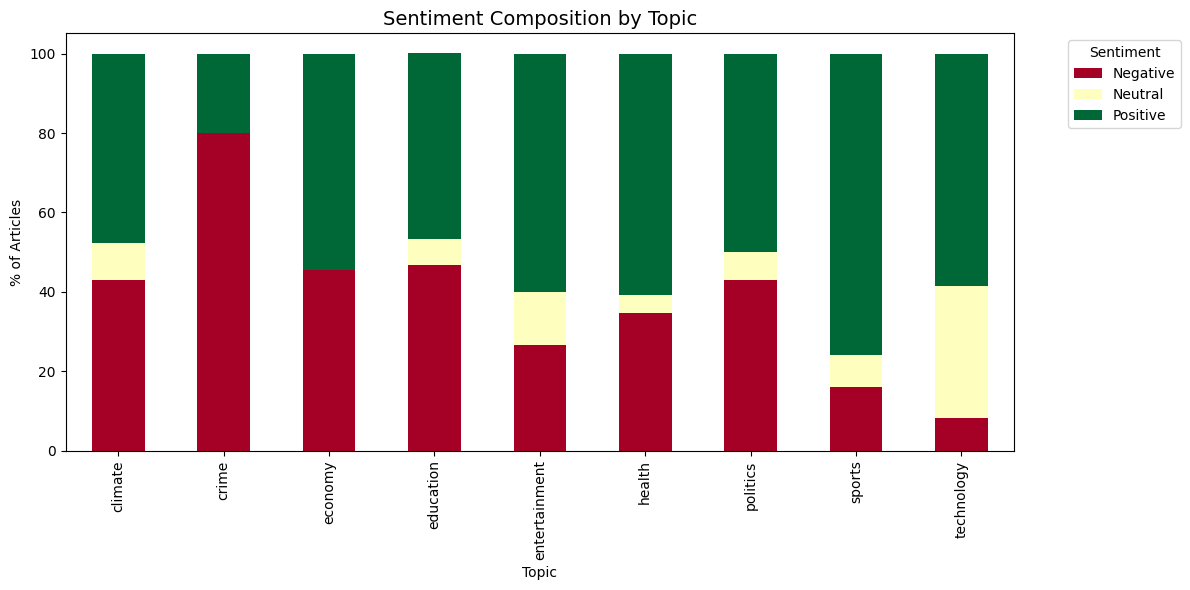

In [19]:
# ================================================================
# VIS 2 — STACKED BAR CHART FOR SENTIMENT BY TOPIC
# ================================================================
sentiment_topic_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    colormap="RdYlGn"
)

plt.title("Sentiment Composition by Topic", fontsize=14)
plt.xlabel("Topic")
plt.ylabel("% of Articles")
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


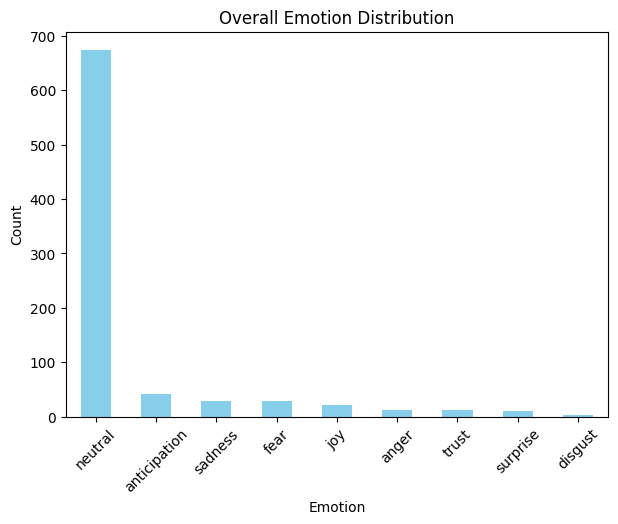

In [22]:
# ================================================================
# VIS 5 — OVERALL EMOTION DISTRIBUTION
# ================================================================
emotion_counts = y_emotion.value_counts()

plt.figure(figsize=(7, 5))
emotion_counts.plot(kind="bar", color="skyblue")
plt.title("Overall Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


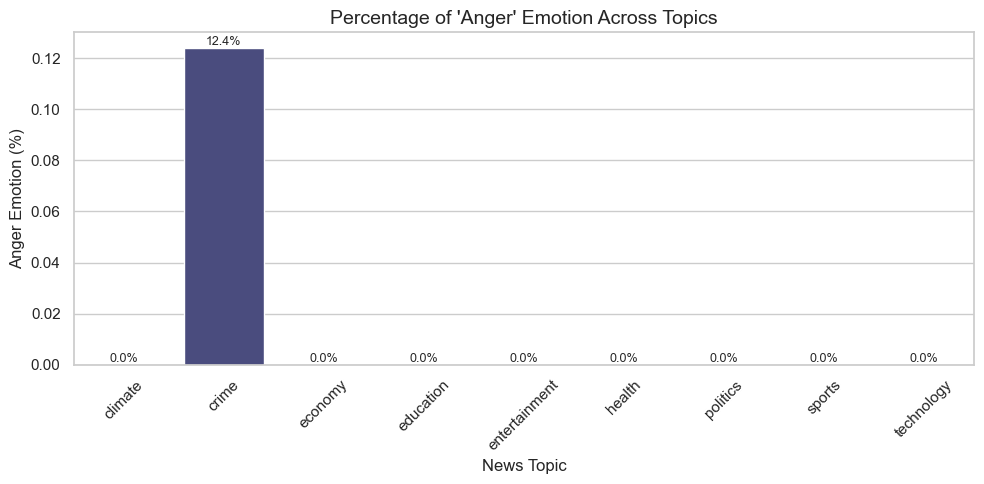

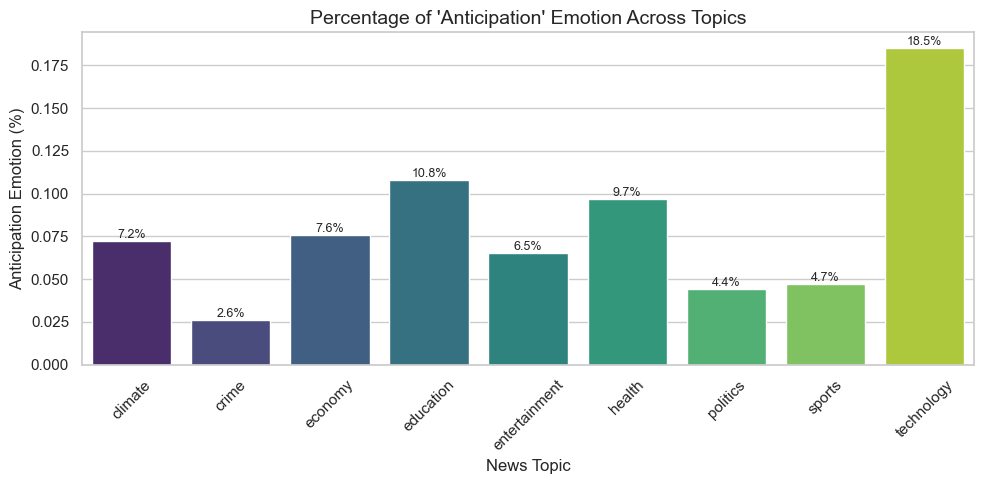

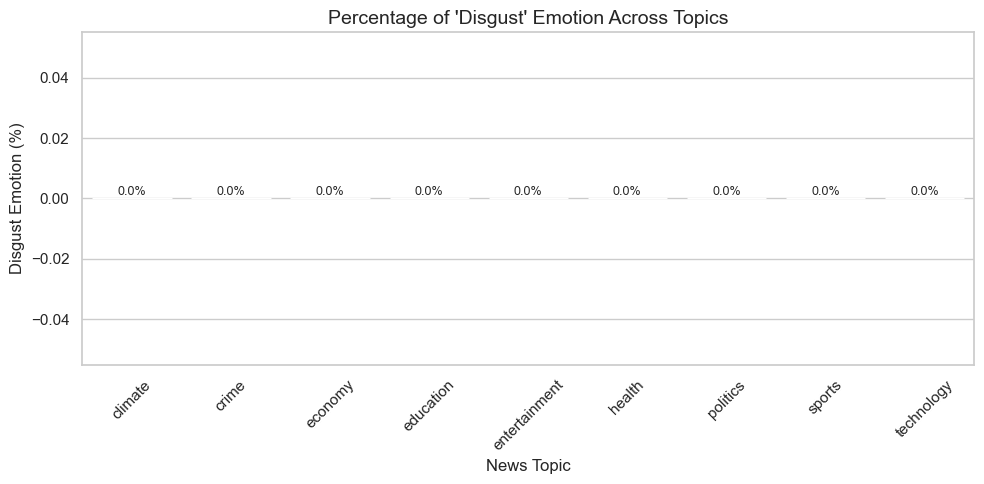

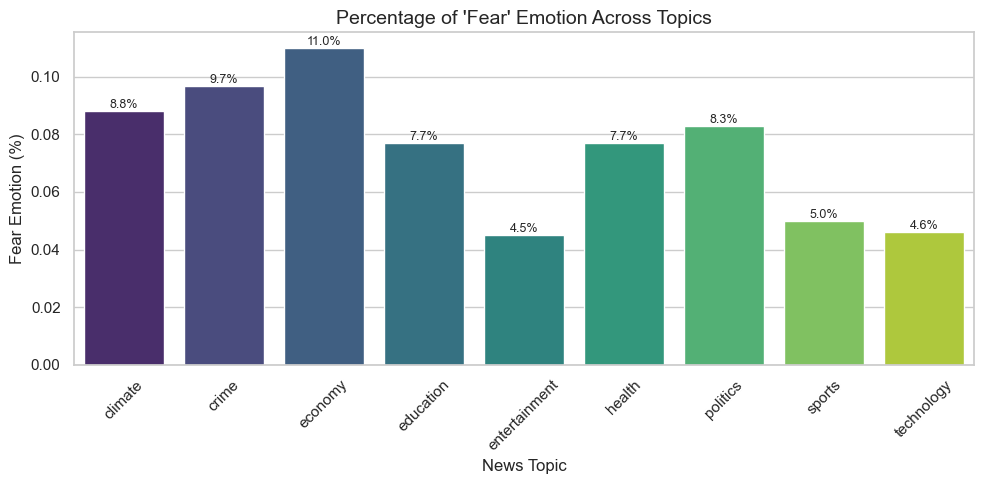

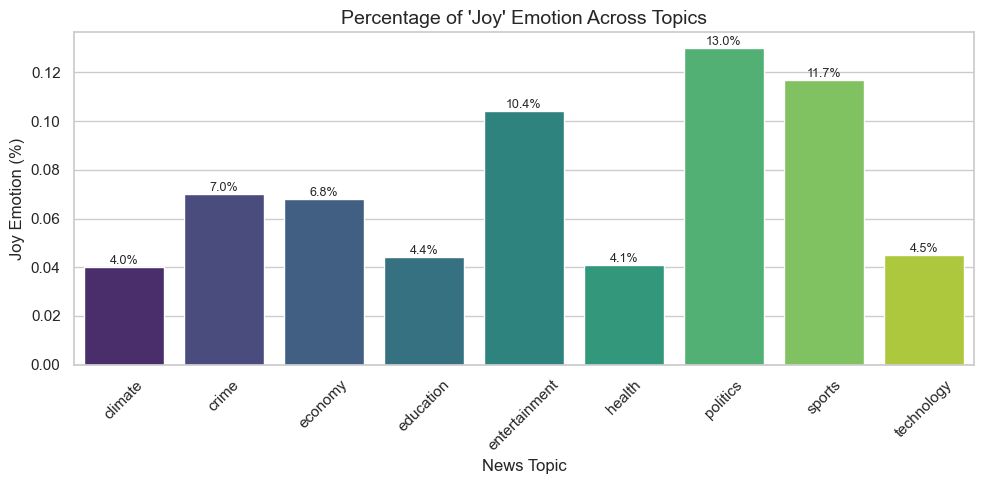

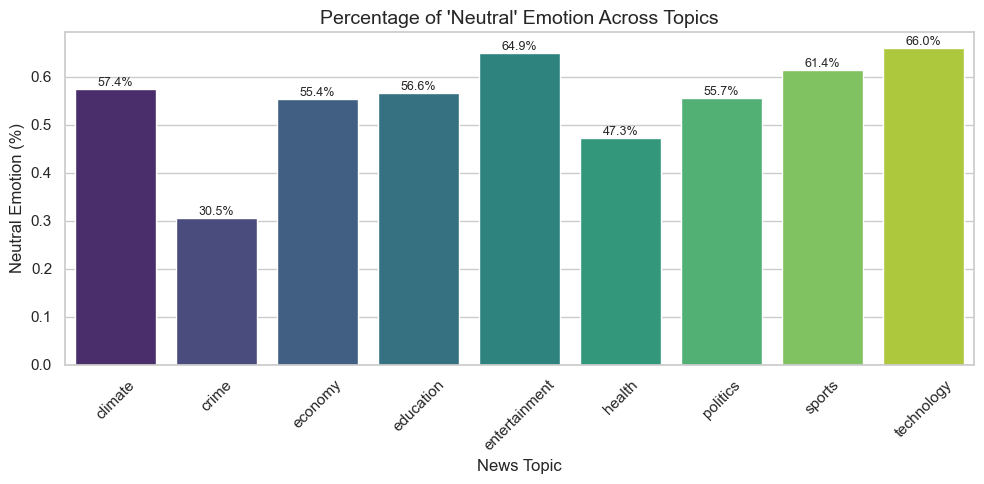

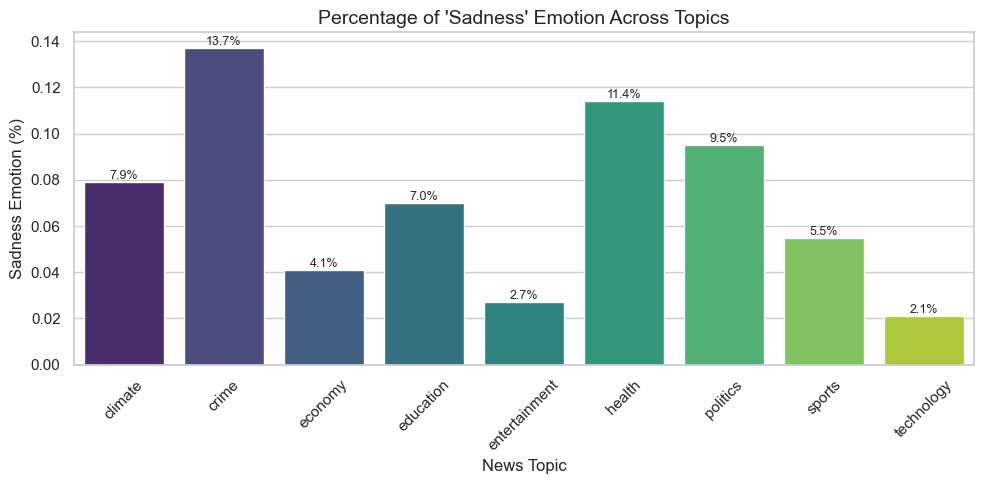

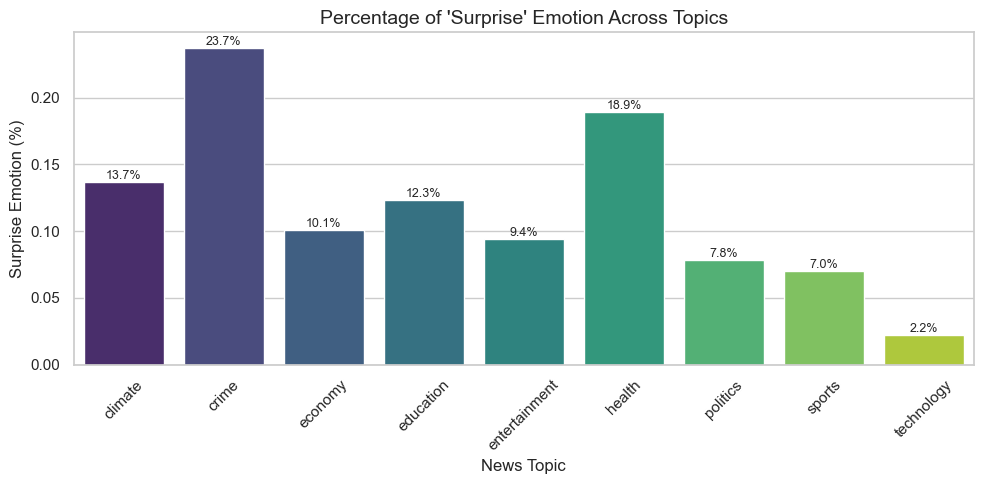

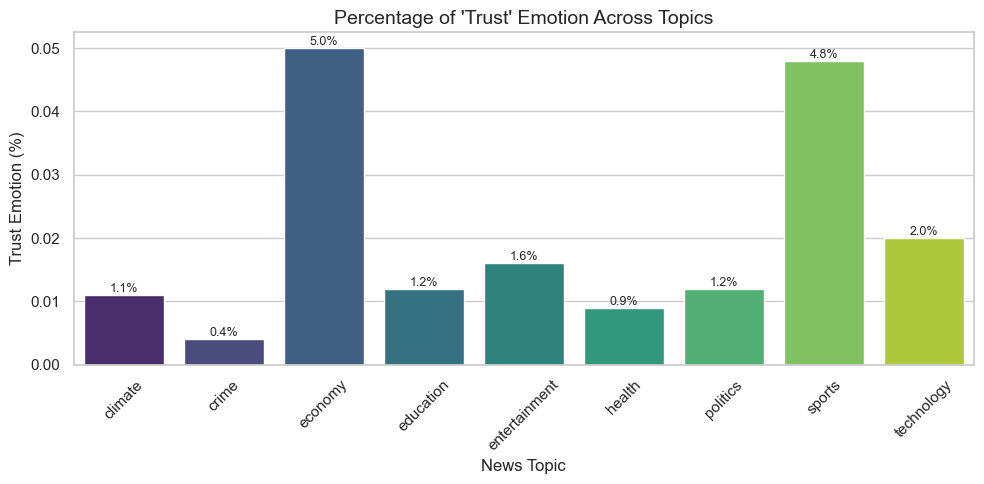

In [23]:
# ================================================================
# VIS — BAR PLOTS FOR EACH EMOTION ACROSS TOPICS
# ================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# nice theme
sns.set(style="whitegrid")

# Get emotion names
emotion_names = [col.replace("emo_prob_", "") for col in emotion_topic_dist.columns]

for emo_col in emotion_topic_dist.columns:
    emo_name = emo_col.replace("emo_prob_", "")
    
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=emotion_topic_dist.reset_index(),
        x="topic",
        y=emo_col,
        palette="viridis"
    )
    
    plt.title(f"Percentage of '{emo_name.capitalize()}' Emotion Across Topics", fontsize=14)
    plt.xlabel("News Topic")
    plt.ylabel(f"{emo_name.capitalize()} Emotion (%)")
    plt.xticks(rotation=45)
    
    # Convert probabilities → percentage labels
    for index, row in emotion_topic_dist.reset_index().iterrows():
        value = row[emo_col] * 100
        plt.text(index, row[emo_col], f"{value:.1f}%", ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
